# Metadata
---

- Created: 2022-09-03
- Last modified: 2022-09-20
- Author: Daniel Kaiser
- Project Identifiers: EMB_ex04
- Last read and understood by: ???
- Changelog:
    - (2022-09-03) Initialized notebook
    - (2022-09-03) Added LFR configuration, new probability models
    - (2022-09-04) Updated parameters
    - (2022-09-06) Updated parameters, added logistic probability model, fixed precision error bug
    - (2022-09-06) Temporarily re-added PCA (removed > v1.3)
    - (2022-09-07) Fixed score bug
    - (2022-09-07) Added "soft" predictions
    - (2022-09-08) Updated "Discussion" Reworked some pathing to make sharing with Filippo easier (removed later same day)
    - (2022-09-12) Added Fast Laplacian Eigenmap Dimensionality Reduction to workflow
    - (2022-09-20) Fixed indexing error

# Preface
---

## Experiment protocol

<!-- Yes, I know the &nbsp is annoying, tabs are automatically removed in basic markdown ok -->
<u>**Experiment ID and project**</u>

EMB_ex04

<u>**Date designed and version**</u>

- 2022-09-03v1.0
- 2022-09-04v1.1
- 2022-09-06v1.2
- 2022-09-06v1.3
- 2022-09-07v2.0
- 2022-09-07v3.0
- 2022-09-12v4.0
- 2022-09-20v4.1

<u>**Date conducted**</u>

- 2022-09-03v1.0
- 2022-09-04v1.1
- 2022-09-06v1.2
- 2022-09-06v1.3
- 2022-09-07v2.0
- 2022-09-07v3.0

<u>**Researcher(s)**</u>

Daniel Kaiser

<u>**Description**</u>

**Purpose**

This experiment is designed to explore the accuracy of multiplex reconstruction utilizing Euclidean distance as a proxy for the likelihood of edge-layer placement. Embedding the "remnant" of each layer of a XOR-aggregated duplex (scale-free layers, configurable edge correlation), an edge to be classified from the aggregate is predicted to originate from the layer whose remnant embedding yields a smaller distance of the edge endpoints.

**Hypothesis (if applicable)**

The expected outcome of this experiment is an AUROC curve of classification that is an increasing function of PFI, decreasing function of degree homogeneity and edge correlation. Note this matches the high-level qualitative results of the naive Bayes approach used in earlier work. (Project identifier "MEC")

<u>**Data & Code**</u>

**Prerequisite data (if applicable)**

This experiment measures AUROC on synthetic, configurable scale-free duplexes. The layers of the duplex are generated according to `Utils.py:lfr_multiplex(N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel)`. The configurable parameters are:

- N; number of nodes (forced exact node overlap in layers)
- $\tau_1$; power-law exponent of degree sequence in each layer
- $\tau_2$; power-law exponent of community size sequence in each layer
- $\mu$; mixing parameter
- $\langle k \rangle$; average degree
- max($k$); maximum degree - forced to be $\sqrt{N}$
- min_community; minimum community size
- prob_relabel; probability to relabel node assignment - breaks community correlations

Additional paramaters include:

- largest_component; flag if remnants should be restricted to largest component (forced with Mercator, optional here to maintain consistency)
- pfi; relative size of multiplex topology observed _a priori_
- metric; probability model selected (see Procedure#5)


**Resultant data**

The resultant data is in the form of a dataframe with columns:
- N
- $\tau_1$
- $\tau_2$
- $\langle k \rangle$
- $\mu$
- prob
- min_community
- largest_component
- pfi
- metric
- Accuracy
- AUROC
- dimensions
- walk_length
- num_walks
- workers
- window
- min_count
- batch_words

Optionally, the node embeddings for each layer of the duplexes associated to each of these dataframe records can be saved as well. They should be saved as pickled numpy arrays of size (N, dimensions).

**Code**

This experiment relies on the script `Utils.py` or functions in this document. All code from `Utils.py` is original or only slightly modified MEC code from @Filippo Radicchi.

@Elior Cohen and node2vec's [GitHub repo](https://github.com/eliorc/node2vec) inspired the function `embed_system`.

Some package version updates in Gensim forced some adjustments - thanks to @555wen on [this StackExchange post](https://stackoverflow.com/questions/67413006/typeerror-init-got-an-unexpected-keyword-argument-size) from @yinky for pointing out a parameter name change. In the site-packages for node2vec, `node2vec.py:175` was altered from `if 'size' not in skip_gram_params:` to `if 'vector_size' not in skip_gram_params:`and `node2vec.py:176` was altered from `skip_gram_params['size'] = self.dimensions` to `skip_gram_params['vector_size'] = self.dimensions`.

<u>**Procedure**</u>

The following procedure was conducted to run this experiment and is sufficient to replicate the workflow along with code described in the "Code" section above.
1. Generate duplex, $\mathcal{M} = (V, (\alpha, \beta))$
2. Aggregate duplex into a monoplex, $G$, and observe some partial information for each layer $\mathcal{O}_{\alpha}, \mathcal{O}_{\beta}$
3. Create remnants by $\mathcal{R}_{\alpha} = G \setminus \mathcal{O}_{\beta}, \mathcal{R}_{\beta} = G \setminus \mathcal{O}_{\alpha}$
4. Embed $\mathcal{R}_{\alpha}, \mathcal{R}_{\beta}$ separately using node2vec. Call the resultant embedded points $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$.
5. For $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$, classify $(i,j)$ as having originated from layer $\alpha$ ($\beta$) with (one minus) the following probability:
    $$
        P((i,j) \in \alpha) = \frac{
            \frac{1}{d_{\alpha}^{\varepsilon}(i,j)}
        }{
            \frac{1}{d_{\alpha}^{\varepsilon}(i,j)} + \frac{1}{d_{\beta}^{\varepsilon}(i,j)}
        }
    $$
    or
    $$
        P((i,j) \in \alpha) = \frac{
            e^{-d_{\alpha}^{\varepsilon}(i,j)}
        }{
            e^{-d_{\alpha}^{\varepsilon}(i,j)} + e^{-d_{\beta}^{\varepsilon}(i,j)}
        }
    $$

6. Calling the true originating layer of $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$ as $l_{ij}$, measure $\| l - \hat{l} \|$
    - NOTE: Since this is a binary classification problem, we actually elect to use the AUROC of the classification of $(i,j) \mapsto \hat{l}_{ij}$ with ground truth $l_{ij}$. The vector norm is simply a more general form of measuring "difference" in our classifications and the ground truth.

## Theoretical foundations and symbol/prior result guide

Will eventually ill in with background from project "MEC" but this seemed like a waste of time at the current moment

# Experiment
---

## Setup

### Imports

In [1]:
# --- Standard library ---
import sys  # System pathing
import os
import yaml  # Configuration files
from datetime import datetime  # Timestamping data
from copy import deepcopy  # Parameter grid processing
from itertools import product

# --- Scientific ---
import numpy as np  # General computational tools
from sklearn import metrics, decomposition  # Measuring classifier performance

# --- Network science ---
import networkx as nx  # General network tools
from node2vec import Node2Vec as N2V  # Embedding tools
from fastlapmap import LapEigenmap  # Laplacian Eigenmap dimensionality reduction

# --- Project source code ---
sys.path.append("../src/")
from Utils import *  # Custom synthetic benchmarks

# --- Data handling and visualization ---
import pandas as pd  # Dataframe tools
from tabulate import tabulate  # Pretty printing for dataframes

import seaborn as sns  # Easier plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# --- Miscellaneous ---
from tqdm.auto import tqdm  # Progress bar

### Globals

In [2]:
# --- Other import aliases ---
today = datetime.today
accuracy = metrics.accuracy_score
auroc = metrics.roc_auc_score

# --- Visualization ---
rc_dict = {
#   "savefig.dpi": 600,  # Saved figure dots-per-inch. 600 is "HD"
  "savefig.facecolor": "white",  # This, combined with transparent setting, keeps saved figs from looking like trash on dark backgrounds 
  "savefig.transparent": False,
#   "figure.figsize": (14, 10),  # Default (width, height) of figure
}
plt.rcParams.update(rc_dict)

### Configuration

In [3]:
# Processing configuration file
config_ = "../workflow/configs/test/LFR.yaml"
with open(config_, 'r') as _fh:
    config = yaml.safe_load(_fh)

# --- Convenience aliasing ---
datafiles_ = config["workflow"]["datafiles"]
pathing_ = config["workflow"]["pathing"]
versioning_ = config["workflow"]["versioning"]

# - Pathing -
tmp = pathing_["TMP"]
raw = pathing_["RAW"]
processed = pathing_["PROCESSED"]
figures = pathing_["FIGURES"]
if not os.path.exists(tmp):
    os.path.mkdir(tmp)

# - Versioning -
project_id = versioning_["project_id"]
current_version = versioning_["current_version"]
researcher = versioning_["researcher"]
date = today().strftime("%Y%m%d")

# - Datafiles -
save_vectors = datafiles_["KEEP_EMBEDDINGS"]
save_dataframe = datafiles_["KEEP_DATAFRAME"]
template_df = datafiles_["TEMPLATE_DF"].format(
    project_id=project_id, current_version=current_version,
    researcher=researcher, date=date
)
template_vectors = datafiles_["TEMPLATE_VECTORS"]  # formatted later

### Functions

In [4]:
def form_system(params):
    # Process parameters
    N = params["N"]
    tau1, tau2 = params["tau1"], params["tau2"]
    mu, min_community = params["mu"], params["min_community"]
    average_degree, max_degree = params["avg_k"], int(np.sqrt(N))
    prob_relabel = params["prob"]
    pfi = params["pfi"]

    # Form "raw" duplex
    D, _sigma1, _sigma2, _mu_temp = lfr_multiplex(N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel)

    # Split into layers
    G, H = duplex_network(D, 1, 2)

    # Observe partial information
    R_G, R_H, testset = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
        edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
        R_G_.add_edges_from(edges_R_G_)
        R_H_.add_edges_from(edges_R_H_)

        testset = {
            edge: gt_
            for edge, gt_ in testset.items()
            if edge in edges_R_H_ | edges_R_H_
        }

    return G, H, R_G, R_H, testset

def embed_system(R_G, R_H, params):
    # Process parameters
    dimensions, walk_length, num_walks = params["dimensions"], params["walk_length"], params["num_walks"]
    workers, window, min_count, batch_words = params["workers"], params["window"], params["min_count"], params["batch_words"]

    # Generate walks
    R_G_emb = N2V(R_G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)
    R_H_emb = N2V(R_H, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)

    # Retrieve embedded models
    G_ = R_G_emb.wv
    H_ = R_H_emb.wv

    return G_, H_

def reconstruct_system(testset, G, H, G_, H_, params):
    cls = []
    scores = []
    gt = []

    _dot = lambda x, y: np.exp(-1*np.dot(np.transpose(x), y))

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)

        v_G_i = G_[i]
        v_G_j = G_[j]
        v_H_i = H_[i]
        v_H_j = H_[j]

        if params["metric"] == "logistic":
            d_G = 1 / (1 + _dot(v_G_i, v_G_j))
            d_H = 1 / (1 + _dot(v_H_i, v_H_j))
        else:
            d_G = np.linalg.norm(v_G_i - v_G_j)
            d_H = np.linalg.norm(v_H_i - v_H_j)

            if params["metric"] == "inverse":
                d_G = 1 / d_G
                d_H = 1 / d_H
            elif params["metric"] == "negexp":
                d_G = np.exp(-d_G)
                d_H = np.exp(-d_H)

        t_G = d_G / (d_G + d_H)
        t_H = 1 - t_G

        scores.append(t_G)

        cls_ = np.random.randint(2)
        if t_G != t_H:
            if np.random.rand() <= t_G:
                cls_ = 1
            else:
                cls_ = 0
        cls.append(cls_)

    return cls, scores, gt

def measure_performance(cls, scores, gt):
    acc = accuracy(gt, cls)
    auc = auroc(gt, scores)

    return acc, auc

### Workflow

In [5]:
def _process_grid(config):
    # Initialize parameter grid
    grid = []

    # Initialize grid vertex archetype
    params = {}

    # Fill in static parameters (mostly embedding)
    params.update(config["experiment"]["embedding"])
    params["largest_component"] = config["experiment"]["params"]["largest_component"]

    # Fill in each vertex with dynamic parameters (network configurations)
    network_ = config["network"]
    network_grid_ = product(*network_.values())
    for repetition in range(config["experiment"]["params"]["repetitions"]):  # repetitions
        for (N, tau1, tau2, mu, avg_k, min_community, prob, pfi) in network_grid_:
            for metric in config["experiment"]["params"]["distance"]:
                params_ = deepcopy(params)

                params_["metric"] = metric

                params_["N"] = N
                params_["tau1"] = tau1
                params_["tau2"] = tau2
                params_["mu"] = mu
                params_["avg_k"] = avg_k
                params_["min_community"] = min_community
                params_["prob"] = prob

                params_["pfi"] = pfi

                params_["repetition"] = repetition
                grid.append(params_)

    return grid

def workflow(config):
    # Process parameter grid
    grid = _process_grid(config)

    # Prepare results dataframe (dict)
    df_ = {key: [] for key in grid[0].keys()}
    df_["Accuracy"] = []
    df_["AUROC"] = []

    # Run experiment
    for gv in tqdm(grid, desc="Experiment Parameter Sweep", colour="purple", ):
        # Track parameters
        for key, value in gv.items():
            df_[key].append(value)

        # Generate synthetic system and form remnants
        G, H, R_G, R_H, agg = form_system(gv)

        # Apply node2vec
        R_G_embedding, R_H_embedding = embed_system(R_G, R_H, gv)

        # Retrieve vectors from embedding model
        # * NOTE: There is some random reindexing occuring
        # * We use explicit index hash map here to avoid making embeddings incomparable
        R_G_vectors = {
            int(R_G_embedding.index_to_key[i]) : R_G_embedding.vectors[i]
            for i in range(G.number_of_nodes())
        }
        R_H_vectors = {
            int(R_H_embedding.index_to_key[i]) : R_H_embedding.vectors[i]
            for i in range(H.number_of_nodes())
        }

        # Save embedding, if applicable
        if save_vectors:
            R_G_embedding.save_word2vec_format(
                    template_vectors.format(
                    tmp=tmp, name="LFR-original",
                    tau1=gv["tau1"], tau2=gv["tau2"], mu=gv["mu"],
                    prob=gv["prob"], pfi=gv["pfi"], repetition=gv["repetition"]
                )+".mat"
            )
            R_H_embedding.save_word2vec_format(
                    template_vectors.format(
                    tmp=tmp, name="LFR-shuffled",
                    tau1=gv["tau1"], tau2=gv["tau2"], mu=gv["mu"],
                    prob=gv["prob"], pfi=gv["pfi"], repetition=gv["repetition"]
                )+".mat"
            )

        # Reconstruct system from embeddings
        cls, scores, gt = reconstruct_system(agg, G, H, R_G_vectors, R_H_vectors, gv)

        # Measure performance
        acc, auc = measure_performance(cls, scores, gt)

        # Update performance measure columns
        df_["Accuracy"].append(acc)
        df_["AUROC"].append(auc)

    # Format dataframe and save
    df = pd.DataFrame(df_)

    if save_dataframe:
        df.to_csv(f"{raw}/{template_df}.csv")

    return df

## Computations

In [6]:
df = workflow(config)

Experiment Parameter Sweep: 100%|██████████| 8/8 [08:15<00:00, 61.99s/it]


In [7]:
print(tabulate(df[["metric", "pfi", "Accuracy", "AUROC"]], headers='keys', tablefmt='fancy_grid'))

╒════╤══════════╤═══════╤════════════╤══════════╕
│    │ metric   │   pfi │   Accuracy │    AUROC │
╞════╪══════════╪═══════╪════════════╪══════════╡
│  0 │ inverse  │  0.05 │   0.503281 │ 0.608055 │
├────┼──────────┼───────┼────────────┼──────────┤
│  1 │ negexp   │  0.05 │   0.590582 │ 0.674203 │
├────┼──────────┼───────┼────────────┼──────────┤
│  2 │ inverse  │  0.33 │   0.517431 │ 0.789788 │
├────┼──────────┼───────┼────────────┼──────────┤
│  3 │ negexp   │  0.33 │   0.710775 │ 0.84197  │
├────┼──────────┼───────┼────────────┼──────────┤
│  4 │ inverse  │  0.67 │   0.551852 │ 0.850787 │
├────┼──────────┼───────┼────────────┼──────────┤
│  5 │ negexp   │  0.67 │   0.740038 │ 0.830074 │
├────┼──────────┼───────┼────────────┼──────────┤
│  6 │ inverse  │  0.95 │   0.55814  │ 0.650862 │
├────┼──────────┼───────┼────────────┼──────────┤
│  7 │ negexp   │  0.95 │   0.494505 │ 0.546154 │
╘════╧══════════╧═══════╧════════════╧══════════╛


In [8]:
print(tabulate(df.loc[df["metric"] == 'inverse'][["pfi", "Accuracy", "AUROC"]], headers='keys', tablefmt='fancy_grid'))

╒════╤═══════╤════════════╤══════════╕
│    │   pfi │   Accuracy │    AUROC │
╞════╪═══════╪════════════╪══════════╡
│  0 │  0.05 │   0.503281 │ 0.608055 │
├────┼───────┼────────────┼──────────┤
│  2 │  0.33 │   0.517431 │ 0.789788 │
├────┼───────┼────────────┼──────────┤
│  4 │  0.67 │   0.551852 │ 0.850787 │
├────┼───────┼────────────┼──────────┤
│  6 │  0.95 │   0.55814  │ 0.650862 │
╘════╧═══════╧════════════╧══════════╛


# Analysis
---

## Post-processing data

## Visualization

### Initial exploration

<Figure size 640x480 with 0 Axes>

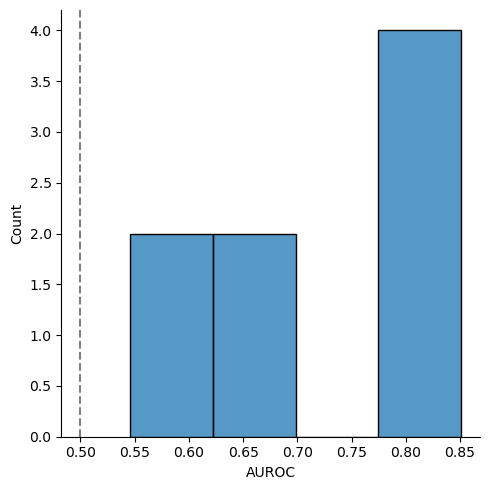

In [21]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/hist_auroc_{template_df}.png")
figure_

<Figure size 640x480 with 0 Axes>

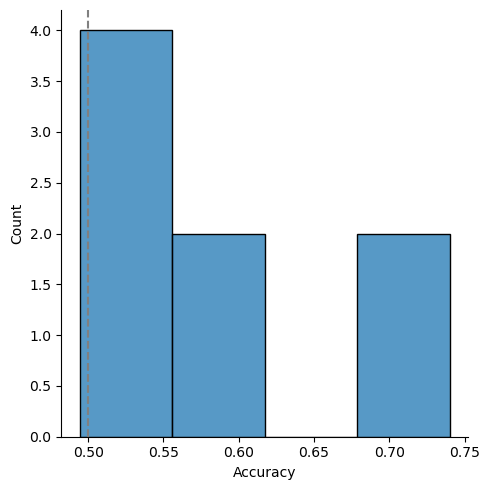

In [22]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="Accuracy"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/hist_accuracy_{template_df}.png")
figure_

### Effect of PFI

<Figure size 640x480 with 0 Axes>

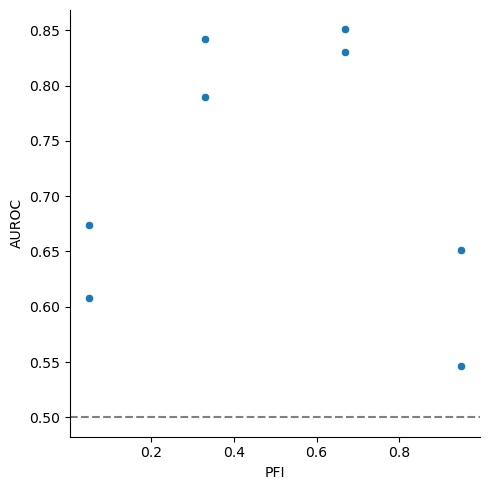

In [24]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/scatter_auroc-pfi_{template_df}.png")
figure_

### Effect of metric

<Figure size 640x480 with 0 Axes>

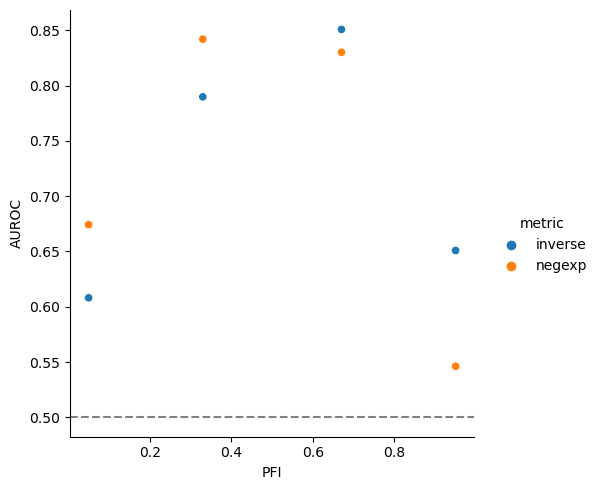

In [31]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
    hue="metric"
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/scatter_auroc-pfi_{template_df}.png")
figure_

### Effect of degree heterogeneity ($\tau_1$)

<Figure size 640x480 with 0 Axes>

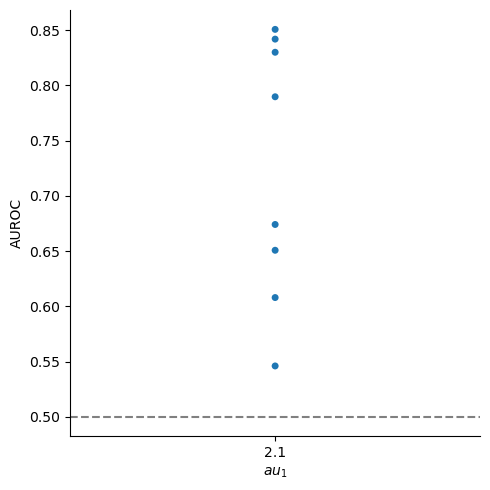

In [27]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="tau1", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("$\tau_1$", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/swarm_auroc-gamma_{template_df}.png")
figure_

<Figure size 640x480 with 0 Axes>

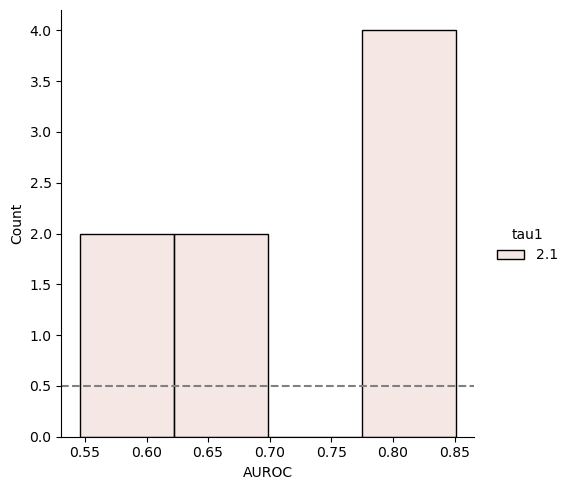

In [29]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="tau1"
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/hist_auroc-gamma_{template_df}.png")
figure_

### Effect of correlation prob

<Figure size 640x480 with 0 Axes>

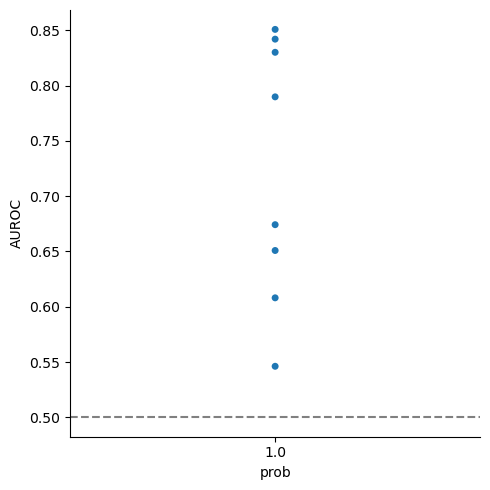

In [30]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="prob", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("prob", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
#plt.savefig(f"{figures}/swarm_auroc-prob_{template_df}.png")
figure_

# Discussion
---

## Observations

With the node indexing fix the classifier appears to be performing significantly better.

More precisely, the performance is increasing as a function of PFI - up to some threshold where it starts to "lose steam." This maximum also appears to correspond to a point where the negative exponential and inverse likelihood functions switch relative performance rankings.

## Interpretations

The dramatic improvement from last week is highly encouraging and suggests that perhaps the entirety of the problem was in the seemingly random reindexing of node vectors, not corresponding to node id.

The concavity and maximum not at supremum boundary, however, is relatively concerning. Specifically, I expected the performance to be an approximately monotonic function of PFI, up to simulation noise.

This was a "debug" run, so very minimal parameter values were explored. Hence, no other parameters have obvious effects here.

## Follow-up

Now that we have a "proof of concept" run, it is time to set up a Snakemake workflow to do a larger sweep.